In [1]:
# This notebook is for voxel-wise correlation of functional and structural gradients (multimodal - struct x func).

# Includes:
#     laoding gradient data
#     checking and saving resampled (to 1.6mm matching func) diffusion gradients
#     BF color coding by coordinate system
#     gradient correlations (struct x func)
#     joint fig of gradient correlation and distribution histogram
#     residuals calculation ie BF subregion most different in struct vs. func gradients

In [1]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import linregress
from copy import copy

### Setting the path

In [2]:
main_path = "/srv/khan/users/sudesnac/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [3]:
# get the current notebook path
note_path = main_path + "/HumanBF-Parcellation/notebook/"
data_path = main_path + "/HumanBF-Parcellation/data/"
results_path = main_path + "/HumanBF-Parcellation/results/Grad_corr/"
fig_path = main_path + "/HumanBF-Parcellation/results/figures/Grad_corr/"

In [4]:
Func_results_path = main_path + "/HumanBF-Parcellation/results/Func_HCPMMP/"
Diff_results_path = main_path + "/HumanBF-Parcellation/results/Diff_7Tsubj7TDWI/"

### Checking & saving resampled dMRI data matched to rfMRI resolution

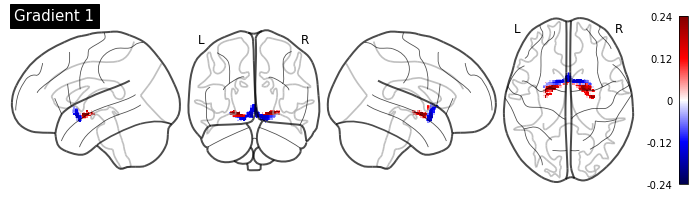

In [6]:
# Checking resampled diffusion gradients
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
# display figures
gradi = 0
grad_nib = nib.load(results_path + f'Diff_resampled_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('seismic')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color)

In [7]:
# saving resampled diff gradients to data frame
DiffRIdx_df = pd.DataFrame()
for gradi in range(5):
    grad_nib = nib.load(results_path + f'Diff_resampled_gradient_{gradi}.nii.gz').get_fdata()
    DiffR_idx = np.argwhere(grad_nib)
    DiffR_values = grad_nib[DiffR_idx[:,0], DiffR_idx[:,1], DiffR_idx[:,2]]
    DiffRIdx_df[str(gradi)] = pd.DataFrame(DiffR_values)

In [8]:
# saving the data frame to csv file
pd.DataFrame(DiffRIdx_df).to_csv(results_path + 'Diff_resampled_gradients_seed-BASF_1p6mm.csv', index=False)

### Loading BF data (nii files)

In [8]:
rfmri_fname = (Func_results_path + 'Func_HCPMMP_gradient_{0}.nii.gz')
dmri_fname = (results_path + 'Diff_resampled_gradient_{0}.nii.gz')

In [9]:
rfmri_g1_nii  = nib.load(rfmri_fname.format(0))
dmri_g1_nii = nib.load(dmri_fname.format(0))

In [10]:
rfmri_g1 = rfmri_g1_nii.get_fdata()
rfmri_mask = np.where(rfmri_g1, 1, 0)

dmri_g1  = dmri_g1_nii.get_fdata()
dmri_mask = np.where(dmri_g1, 1, 0)

#### Creating combined mask and color-coded BF

In [11]:
combined_mask = np.zeros_like(dmri_mask)
combined_mask[(dmri_mask==1) & (rfmri_mask==1)] = 1

In [12]:
# Get X, Y, Z coordinates
ijk_indices = np.argwhere(combined_mask)
ijk_indices = np.hstack((ijk_indices,np.ones((len(ijk_indices),1))))

affine = rfmri_g1_nii.affine

xyz_coords = np.dot(ijk_indices, affine)

In [13]:
# Here we flip along the X axis to give left and right same color codes
new_ijk_indices = ijk_indices.copy()
new_ijk_indices[:,0] = np.abs((combined_mask.shape[0]/2)-ijk_indices[:,0])

In [14]:
# Create RGB array
min_max_scaler = preprocessing.MinMaxScaler()

c_com = np.zeros((len(new_ijk_indices),3))
c_com[:,0] = min_max_scaler.fit_transform(new_ijk_indices[:,0][:,np.newaxis])[:,0]
c_com[:,1] = min_max_scaler.fit_transform(new_ijk_indices[:,1][:,np.newaxis])[:,0]
c_com[:,2] = min_max_scaler.fit_transform(new_ijk_indices[:,2][:,np.newaxis])[:,0]

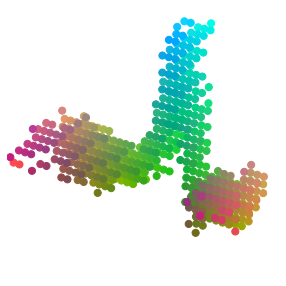

In [15]:
# combined functional x diffusion mask for func vs. diff correlation
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(projection='3d')
ax2.dist=6
ax2.set_axis_off()

ax2.scatter(
    ijk_indices[:,0],
    ijk_indices[:,1],
    ijk_indices[:,2],
    s=50, alpha=1,
    c=c_com
)

plt.show()

### Gradient Correlation structural vs functional - all gradients Rs 

#### Linear least-square regression

In [49]:
r2_matrix = np.zeros((5,5))
r_matrix = np.zeros((5, 5))
p_matrix = np.zeros((5, 5))
reg_results = pd.DataFrame()
dmri_rescaled = pd.DataFrame()
rfmri_rescaled = pd.DataFrame()

for g in range(0,5):
    dmri_g = nib.load(dmri_fname.format(g)).get_fdata()
    dmri_g_rescaled = min_max_scaler.fit_transform(dmri_g[combined_mask==1][:,np.newaxis])
    dmri_rescaled[g] = pd.DataFrame(dmri_g_rescaled)

    for gg in range(0,5):
        rfmri_g = nib.load(rfmri_fname.format(gg)).get_fdata()
        rfmri_g_rescaled = min_max_scaler.fit_transform(rfmri_g[combined_mask==1][:,np.newaxis])
        rfmri_rescaled[gg] = pd.DataFrame(rfmri_g_rescaled)
        
        res = linregress(dmri_g[combined_mask==1].flatten(), rfmri_g[combined_mask==1].flatten())
        
        reg_results[g,gg] = pd.DataFrame(res)
        r2_matrix[g,gg] = res.rvalue**2
        r_matrix[g,gg] = res.rvalue
        p_matrix[g,gg] = res.pvalue
        
index = pd.Index(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])
reg_results = reg_results.set_index(index)       

In [14]:
pd.DataFrame(reg_results).to_csv(results_path + 'Struct_vs_Func_linear_least-squares_regression_results_scipy.csv', index=False)
pd.DataFrame(dmri_rescaled).to_csv(results_path + 'BF_Structural_gradients_rescaled-0to1.csv', index=False)
pd.DataFrame(rfmri_rescaled).to_csv(results_path + 'BF_Functional_gradients_rescaled-0to1.csv', index=False)

In [50]:
# Define the gradient labels so it starts from 1 instead of 0
x_axis_labels = [1,2,3,4,5] # labels for x-axis
y_axis_labels = [1,2,3,4,5] # labels for y-axis

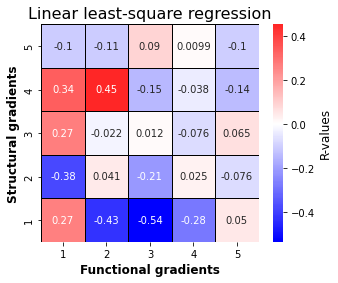

In [51]:
# plot r-values
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(r_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-values'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Linear least-square regression', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_linear_least-squares_regression_R-values.png', dpi=300)
plt.show()

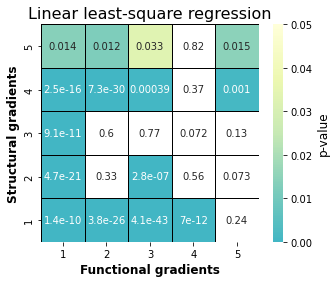

In [52]:
# plot significant p-values
from copy import copy
#conditions for filtering p<=0.05
val_max = 0.05

fig, ax = plt.subplots(1,1, figsize=(5,4))

#define the colormap with clipping values
my_cmap = copy(plt.cm.YlGnBu_r)
my_cmap.set_over("white")
my_cmap.set_under("white")

sns.heatmap(p_matrix, vmax=val_max, cmap=my_cmap, center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'p-value'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.invert_yaxis()
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Linear least-square regression', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_linear_least-squares_regression_p-values.png', dpi=300)
plt.show()

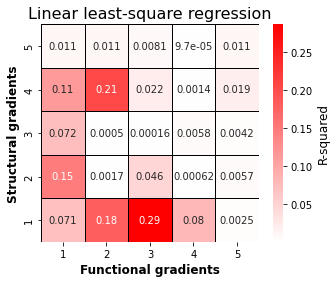

In [53]:
# plot r-squared
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(r2_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-squared'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Linear least-square regression', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_linear_least-squares_regression_R-squared_scipy.png', dpi=300)
plt.show()

In [19]:
# average of R-squared over all 5x5 gradients
r2_matrix.mean()

0.052250974096828315

#### Pearson correlation

In [45]:
from scipy import stats
pcorr_matrix = np.zeros((5,5))
pp_matrix = np.zeros((5, 5))
pr2_matrix = np.zeros((5, 5))

for g in range(0,5):
    dmri_g = nib.load(dmri_fname.format(g)).get_fdata()
    dmri_g_rescaled = min_max_scaler.fit_transform(dmri_g[combined_mask==1][:,np.newaxis])    

    for gg in range(0,5):
        rfmri_g = nib.load(rfmri_fname.format(gg)).get_fdata()
        rfmri_g_rescaled = min_max_scaler.fit_transform(rfmri_g[combined_mask==1][:,np.newaxis])
        
        pearsonr, pearsonp = stats.pearsonr(dmri_g[combined_mask==1].flatten(), rfmri_g[combined_mask==1].flatten())
        
        pcorr_matrix[g,gg] = pearsonr
        pp_matrix[g,gg] = pearsonp
        pr2_matrix[g,gg] = pearsonr**2

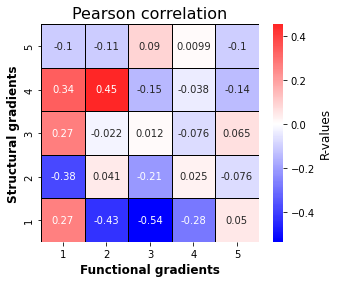

In [46]:
# plot pearson r-values
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(pcorr_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-values'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Pearson correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_pearson_correlation_R-values.png', dpi=300)
plt.show()

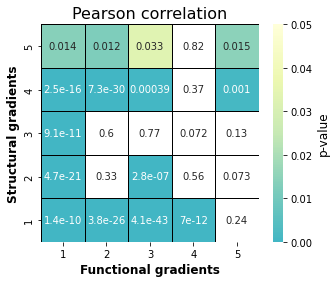

In [47]:
# plot pearson p-values
from copy import copy
#conditions for filtering p<=0.05
val_max = 0.05

fig, ax = plt.subplots(1,1, figsize=(5,4))

#define the colormap with clipping values
my_cmap = copy(plt.cm.YlGnBu_r)
my_cmap.set_over("white")
my_cmap.set_under("white")

sns.heatmap(pp_matrix, vmax=val_max, cmap=my_cmap, center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'p-value'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Pearson correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_pearson_correlation_p-values.png', dpi=300)
plt.show()

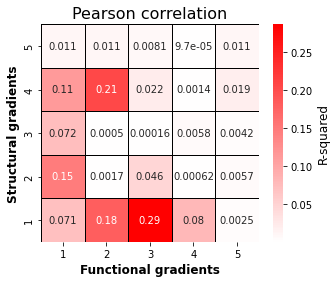

In [48]:
# plot pearson r-squared-values
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(pr2_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-squared'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Pearson correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_pearson_correlation_R-squared.png', dpi=300)
plt.show()

#### Spearman correlation

In [40]:
from scipy import stats
spearmanr_matrix = np.zeros((5,5))
spearmanp_matrix = np.zeros((5, 5))
spearmanr2_matrix = np.zeros((5, 5))

for g in range(0,5):
    dmri_g = nib.load(dmri_fname.format(g)).get_fdata()
    dmri_g_rescaled = min_max_scaler.fit_transform(dmri_g[combined_mask==1][:,np.newaxis])    

    for gg in range(0,5):
        rfmri_g = nib.load(rfmri_fname.format(gg)).get_fdata()
        rfmri_g_rescaled = min_max_scaler.fit_transform(rfmri_g[combined_mask==1][:,np.newaxis])
        
        spearmanr, spearmanp = stats.spearmanr(dmri_g[combined_mask==1].flatten(), rfmri_g[combined_mask==1].flatten())
        
        spearmanr_matrix[g,gg] = spearmanr
        spearmanp_matrix[g,gg] = spearmanp
        spearmanr2_matrix[g,gg] = spearmanr**2

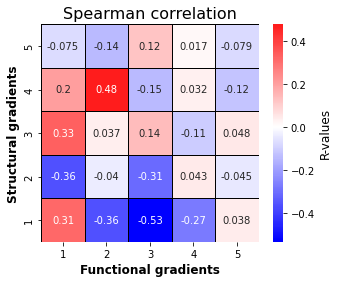

In [41]:
# plot pearson r-values
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(spearmanr_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-values'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Spearman correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_spearman_correlation_R-values.png', dpi=300)
plt.show()

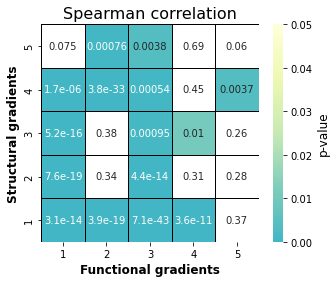

In [42]:
# plot pearson p-values
from copy import copy
#conditions for filtering p<=0.05
val_max = 0.05

fig, ax = plt.subplots(1,1, figsize=(5,4))

#define the colormap with clipping values
my_cmap = copy(plt.cm.YlGnBu_r)
my_cmap.set_over("white")
my_cmap.set_under("white")

sns.heatmap(spearmanp_matrix, vmax=val_max, cmap=my_cmap, center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'p-value'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Spearman correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_spearman_correlation_p-values.png', dpi=300)
plt.show()

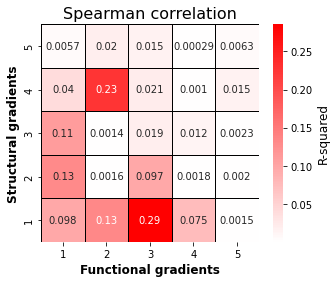

In [44]:
# plot pearson r-squared-values
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(spearmanr2_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-squared'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Spearman correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_spearman_correlation_R-squared.png', dpi=300)
plt.show()

In [54]:
# average of R-squared over all 5x5 gradients
spearmanr2_matrix.mean()

0.05286131310517705

### Structural vs Functional gradient correlations

#### Correlation SG1 vs. FG1 (specify G)

In [25]:
# Rescale gradient (G1) values between 0 and 1
dmri_rescaled = min_max_scaler.fit_transform(dmri_g1[combined_mask==1][:,np.newaxis])
rfmri_rescaled = min_max_scaler.fit_transform(rfmri_g1[combined_mask==1][:,np.newaxis])

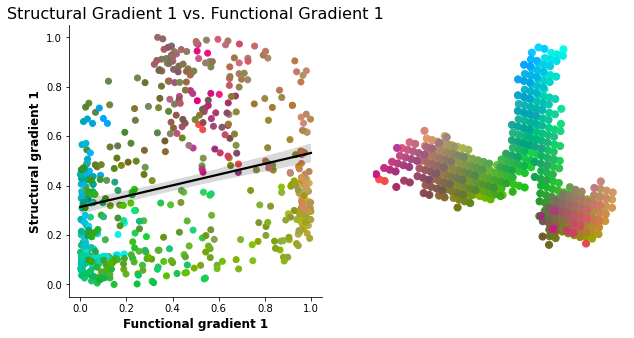

In [26]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)

ax1.scatter(rfmri_rescaled, dmri_rescaled, c=c_com)

ax1.set_xlabel('Functional gradient 1', weight='bold', fontsize=12)
ax1.set_ylabel('Structural gradient 1', weight='bold', fontsize=12)

plt.title("Structural Gradient 1 vs. Functional Gradient 1", fontsize=16)
# Add fit line
sns.regplot(
    x=rfmri_rescaled,
    y=dmri_rescaled,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

# Add 3D scatterplot for visualizing RGB values
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.dist=6
ax2.set_axis_off()

ax2.scatter(
    ijk_indices[:,0],
    ijk_indices[:,1],
    ijk_indices[:,2],
    s=50, alpha=1,
    c=c_com
)

plt.show()

#### Structural vs Functional correlation for G1 to G5

In [28]:
# load the data
struct_rescaled = pd.read_csv(results_path + 'BF_Structural_gradients_rescaled-0to1.csv')
func_rescaled = pd.read_csv(results_path + 'BF_Functional_gradients_rescaled-0to1.csv')

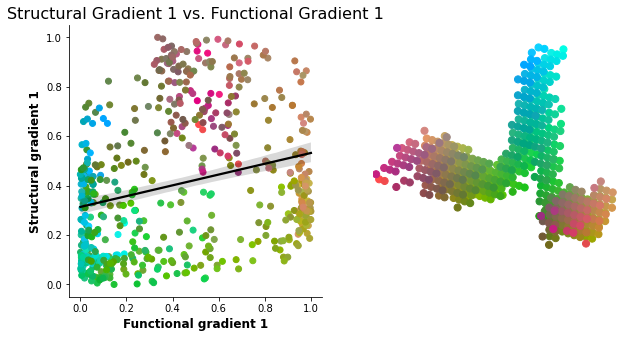

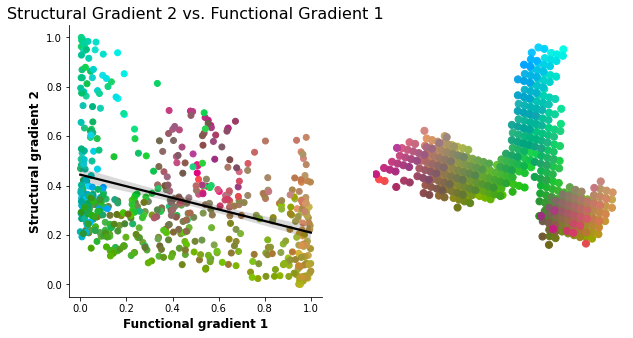

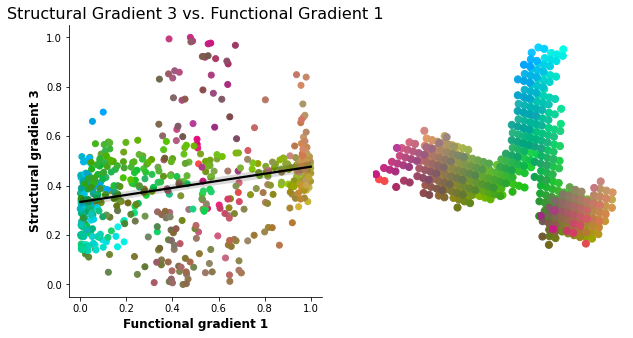

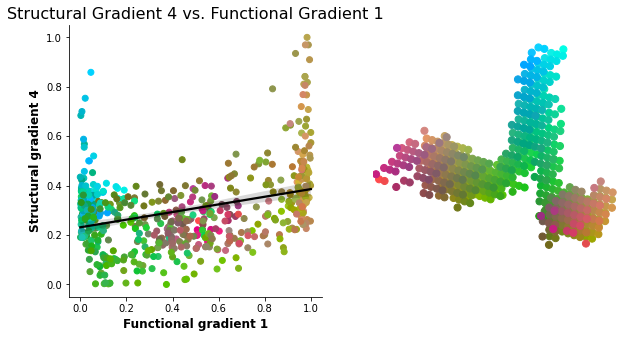

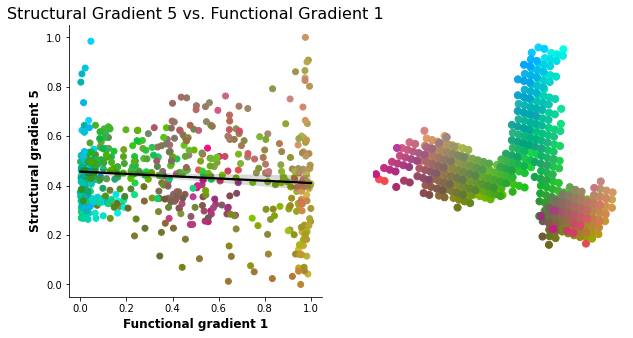

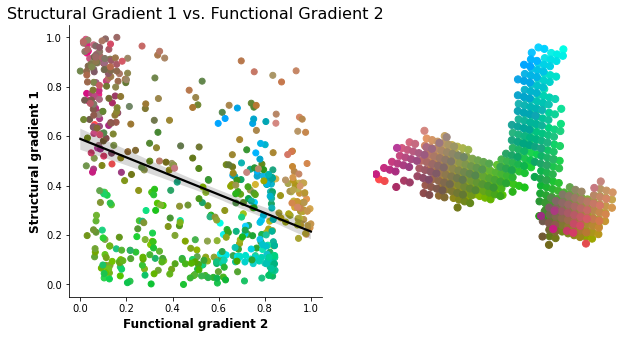

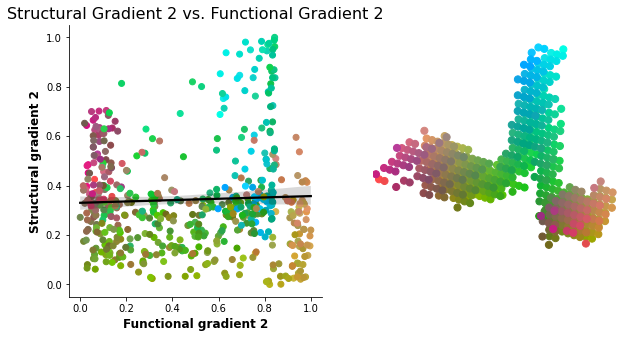

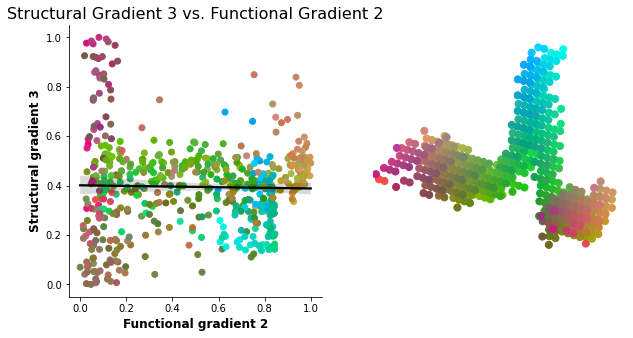

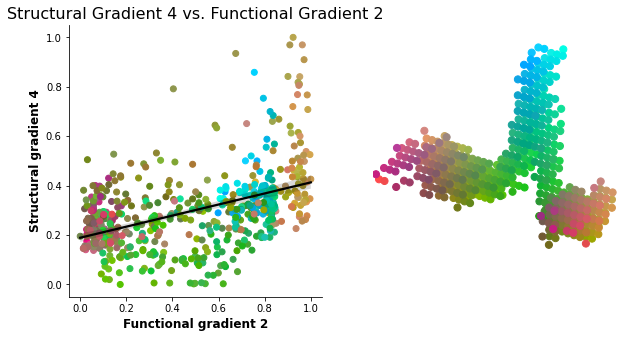

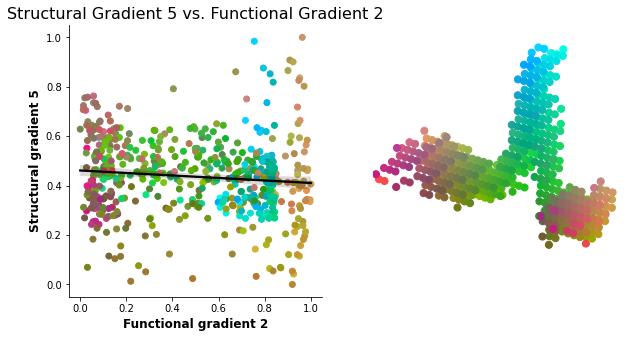

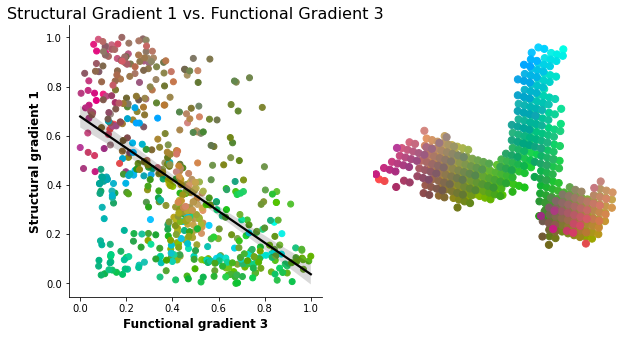

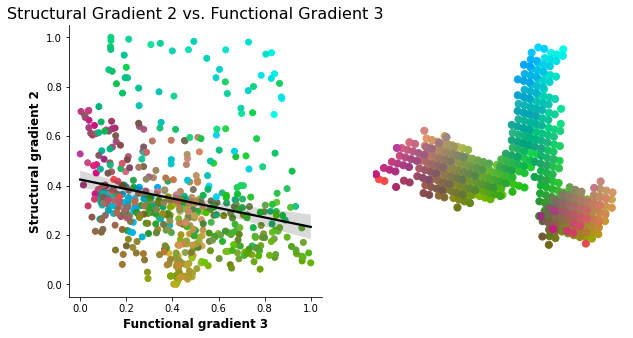

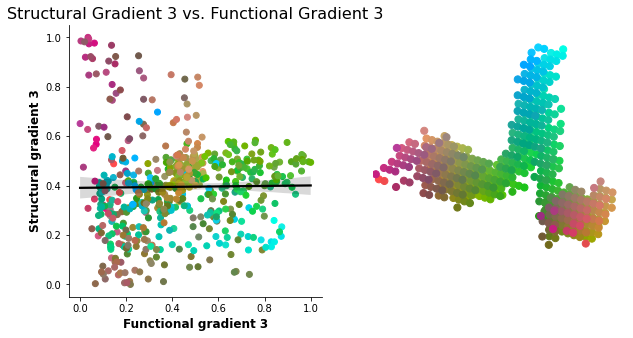

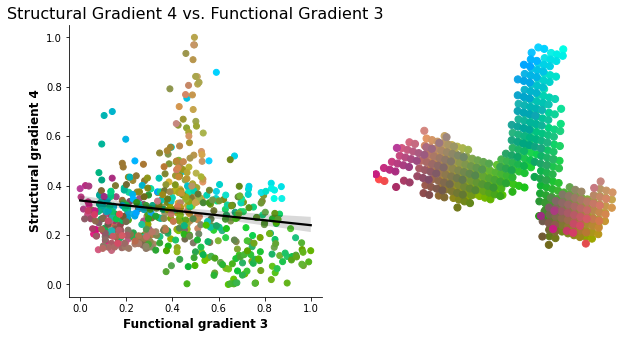

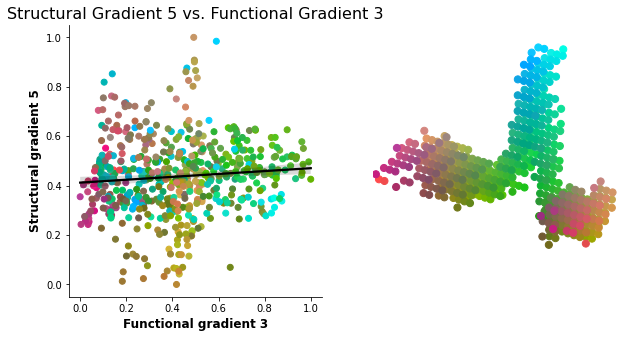

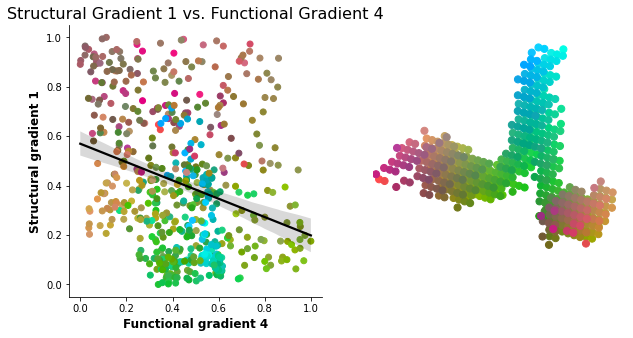

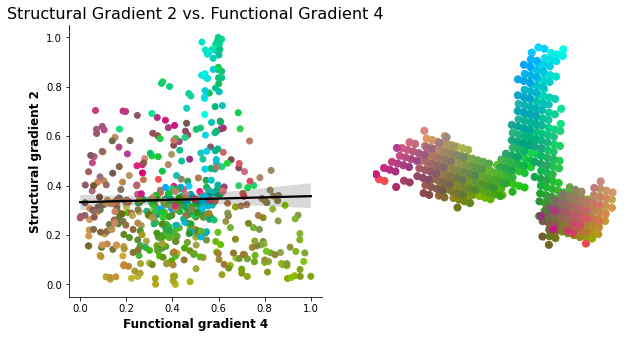

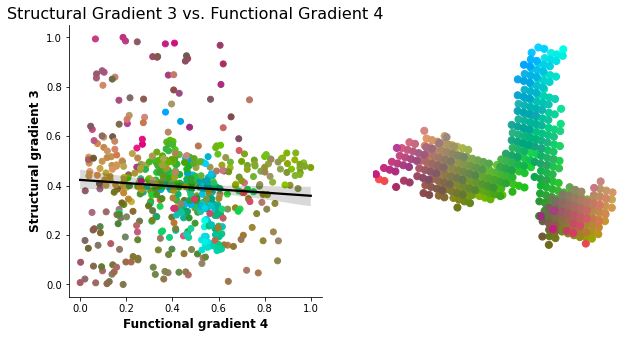

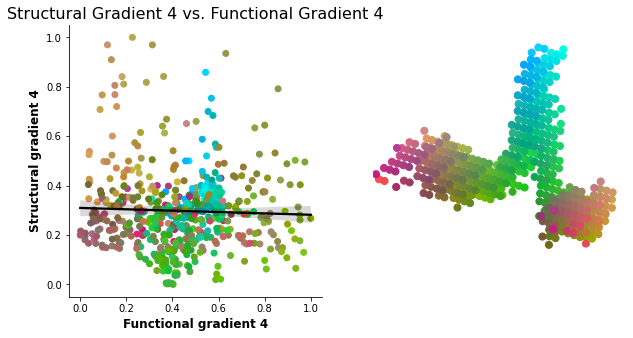

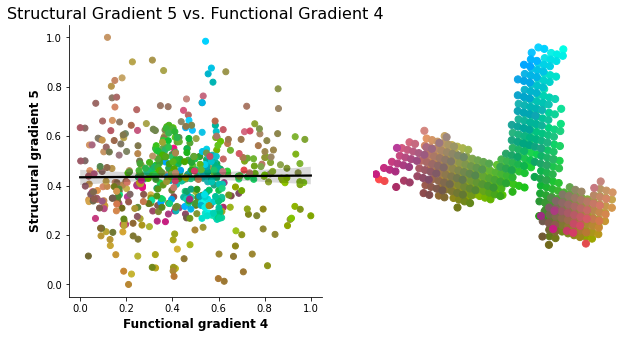

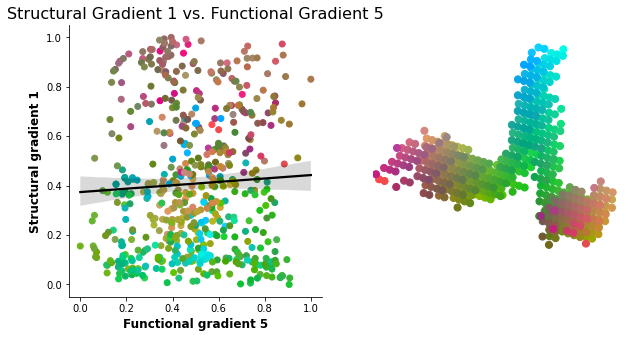

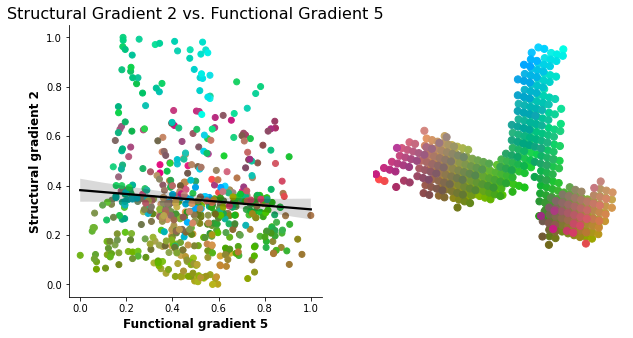

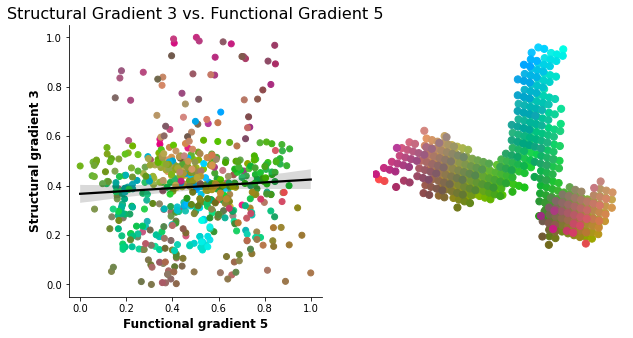

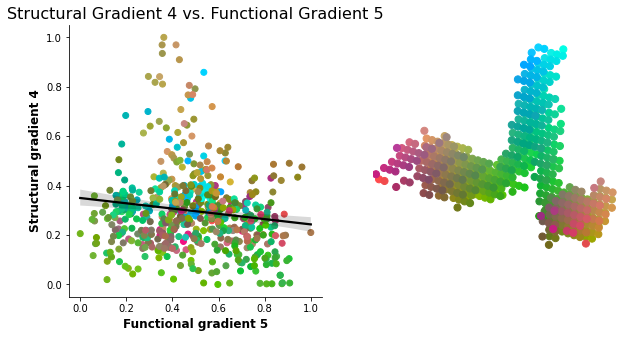

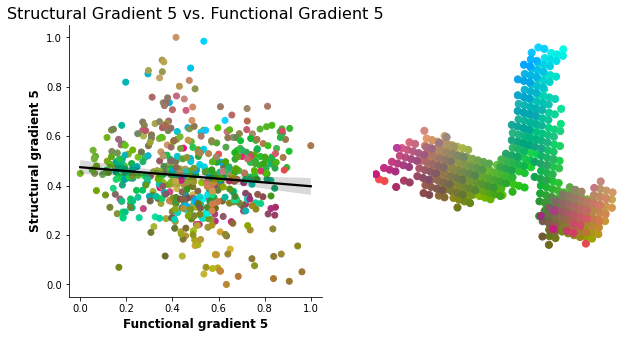

In [58]:
for fg in range(0,5):
    for dg in range(0,5):
        # Plot scatterplot colorcoded for XYZ coordinates
        fig = plt.figure(figsize=(10,5))
        ax1 = fig.add_subplot(1,2,1)
        
        x=func_rescaled[str(fg)].to_numpy()
        y=struct_rescaled[str(dg)].to_numpy()
        
        ax1.scatter(x,y,c=c_com)
        
        ax1.set_xlabel("Functional gradient "+str(fg+1), weight='bold', fontsize=12)
        ax1.set_ylabel("Structural gradient "+str(dg+1), weight='bold', fontsize=12)

        plt.title("Structural Gradient " + str(dg+1) + " vs. Functional Gradient " + str(fg+1), fontsize=16)
        
        # Add fit line
        sns.regplot(
            x=x,
            y=y,
            scatter=False, line_kws={'color': 'black'},
            ax=ax1)
        sns.despine()
                
        # Add 3D scatterplot for visualizing RGB values
        ax2 = fig.add_subplot(1,2,2, projection='3d')
        ax2.dist=6
        ax2.set_axis_off()
        ax2.scatter(ijk_indices[:,0],ijk_indices[:,1],ijk_indices[:,2],s=50, alpha=1,c=c_com)
        
        plt.savefig(fig_path + f'BF_Gradient_Struct_g-'+str(dg+1)+'_vs_Func_g-'+str(fg+1)+'_scaled-0to1.png', dpi=300)
        plt.show()

#### Structural vs Functional correlation and distribution

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:1670: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


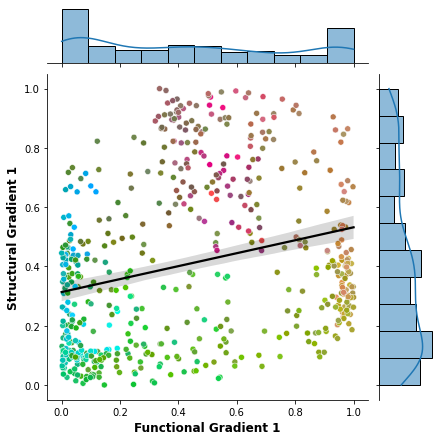

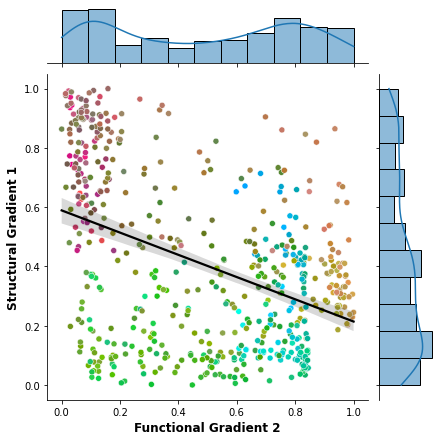

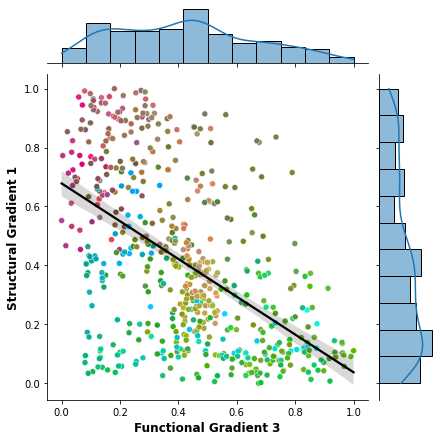

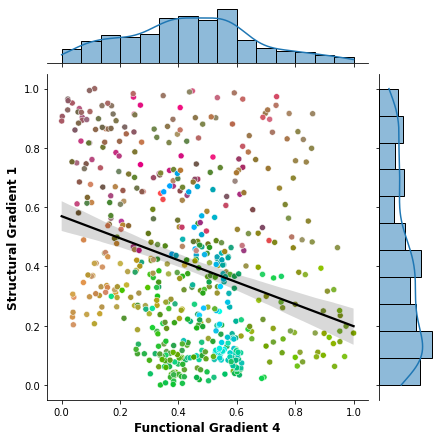

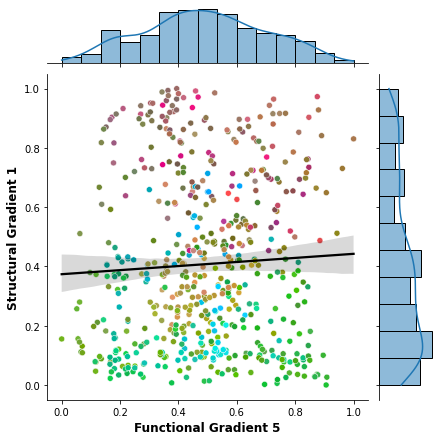

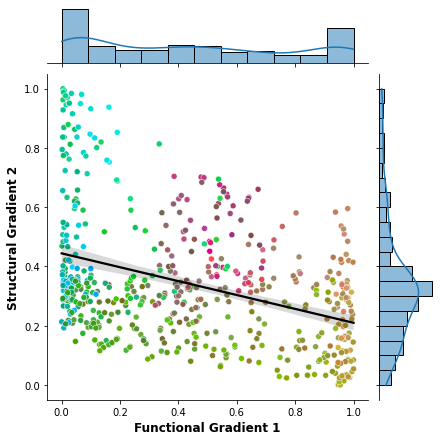

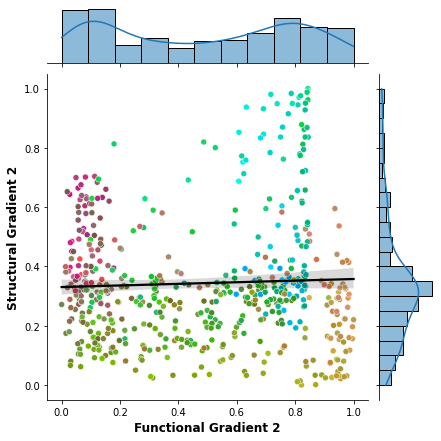

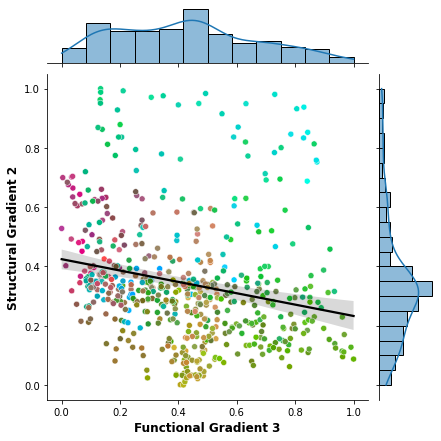

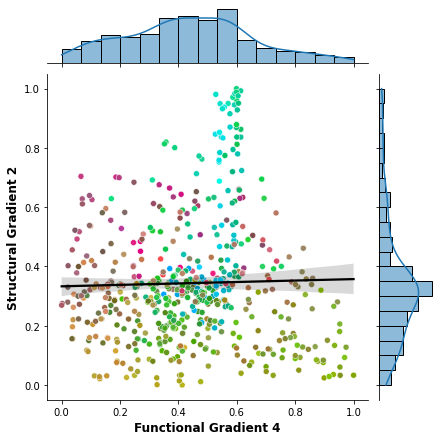

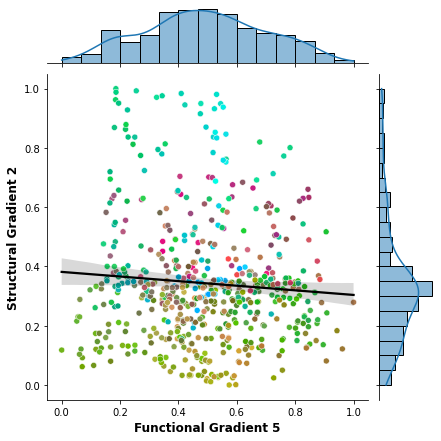

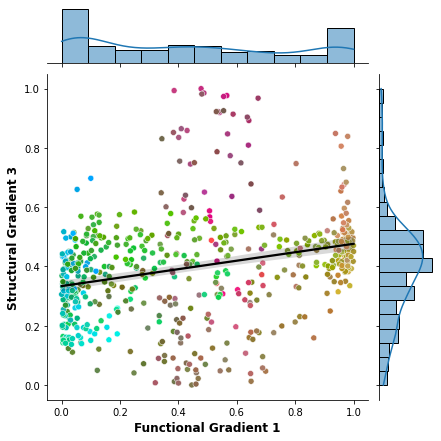

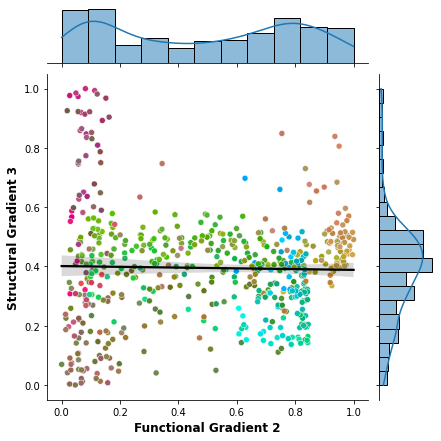

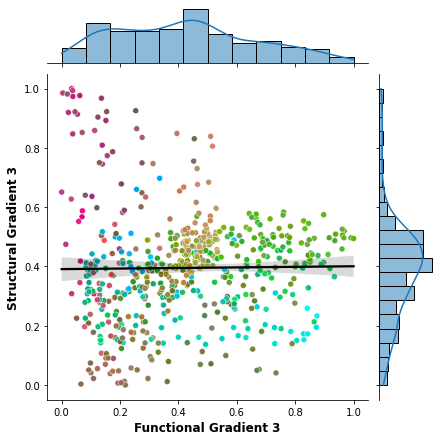

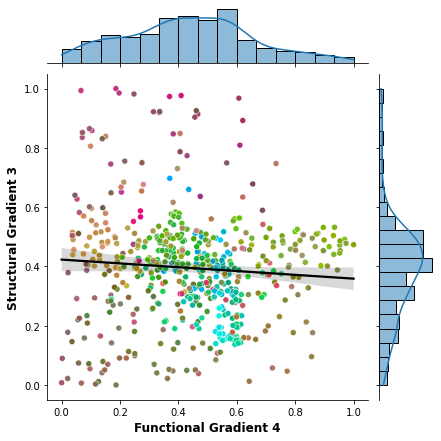

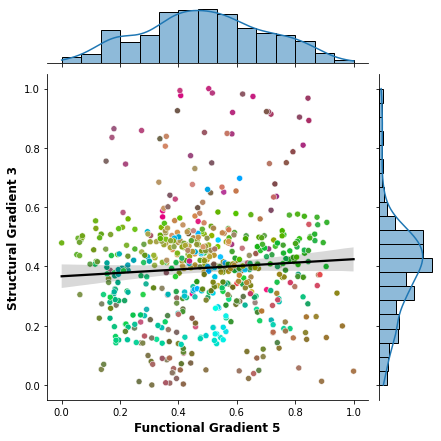

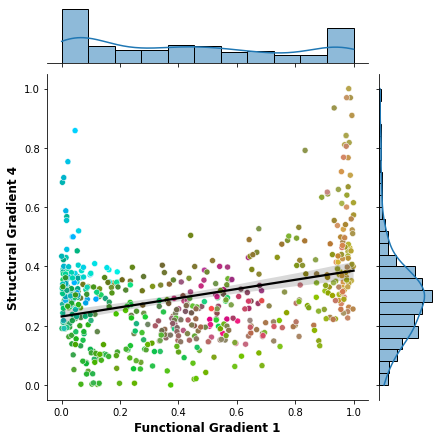

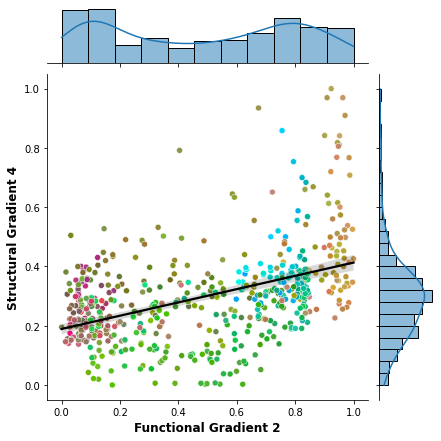

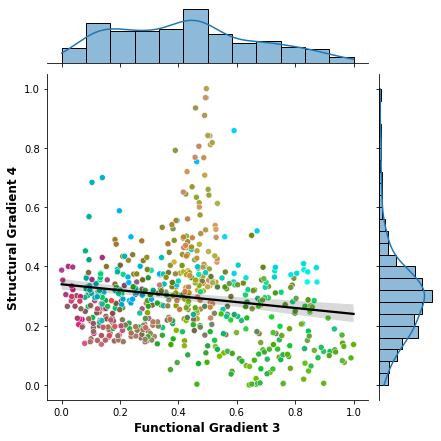

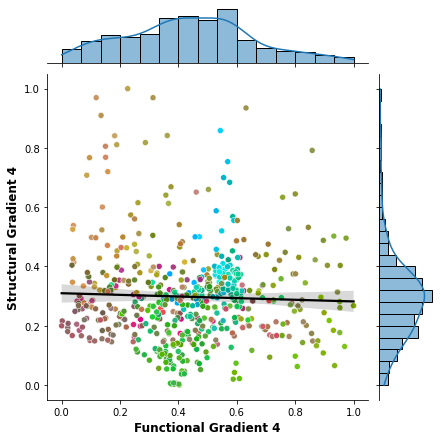

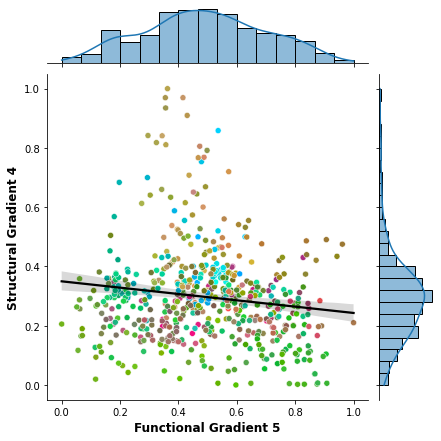

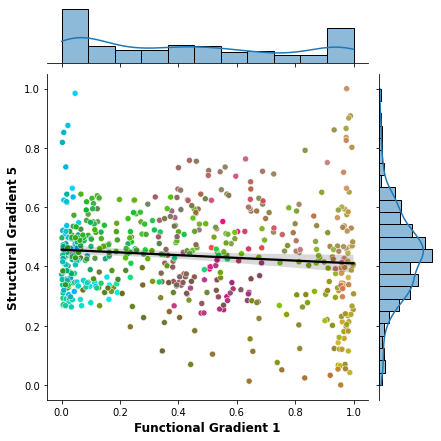

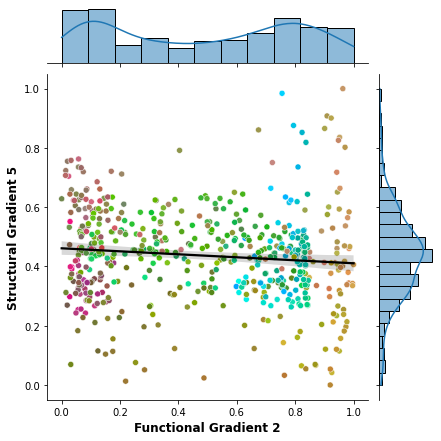

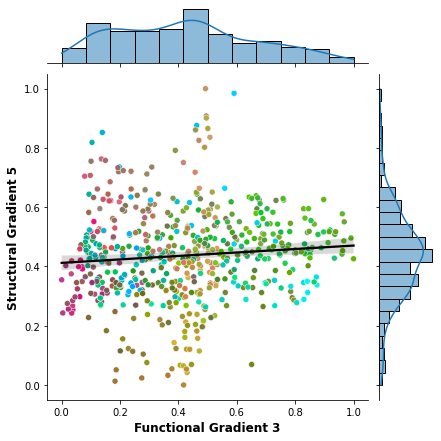

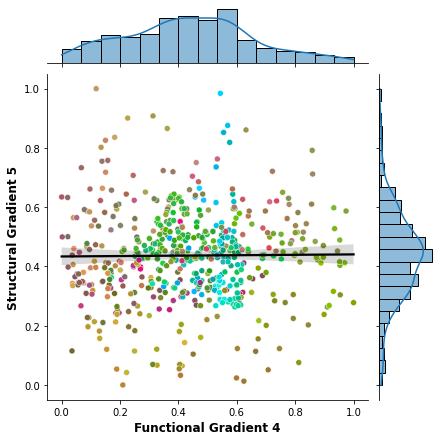

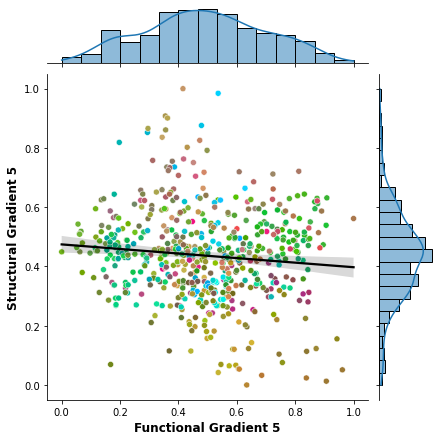

In [29]:
for dg in range(0,5): 
    for fg in range(0,5):
        
        x=func_rescaled[str(fg)].to_numpy()
        y=struct_rescaled[str(dg)].to_numpy()
        
        g = sns.JointGrid(x=x, y=y)
        g.plot_joint(sns.scatterplot, c=c_com)
        g.plot_marginals(sns.histplot, kde=True)
        g1 = sns.regplot(x=x, y=y, scatter=False, line_kws={'color': 'black'}, ax=g.ax_joint)
        g.set_axis_labels(xlabel=f'Functional Gradient '+str(fg+1), ylabel=f'Structural Gradient '+str(dg+1), weight='bold', fontsize=12)
        g.savefig(fig_path + f'BF_resampled&scaled_Gradients_correlation_and_distribution_Structural_g-'+ str(dg+1)+'_vs_Functional_g-'+ str(fg+1)+'.png', dpi=300)

### Calculating residuals

In [5]:
# load the data
rfmri_fname = (Func_results_path + 'Func_HCPMMP_gradient_{0}.nii.gz')
dmri_fname = (results_path + 'Diff_resampled_gradient_{0}.nii.gz')

In [55]:
rsq_matrix = np.zeros((5,5))
resid_results = pd.DataFrame()

import statsmodels.api as sm
for dg in range(0,5):
    dmri_g = nib.load(dmri_fname.format(dg)).get_fdata()

    for fg in range(0,5):
        rfmri_g = nib.load(rfmri_fname.format(fg)).get_fdata()
        
        model = sm.OLS(rfmri_g[combined_mask==1].flatten(), dmri_g[combined_mask==1].flatten())
        results = model.fit()
        
        rsq_matrix[dg,fg] = results.rsquared
        resid_results[dg,fg] = pd.DataFrame(results.resid)

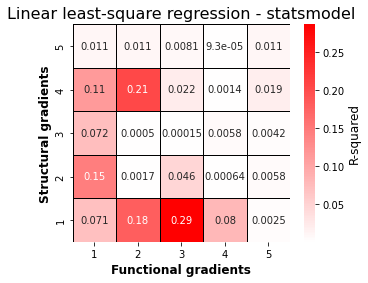

In [59]:
# plot r-squared to double check
fig, ax = plt.subplots(1,1, figsize=(5,4))
# Define the gradient labels so it starts from 1 instead of 0
x_axis_labels = [1,2,3,4,5] # labels for x-axis
y_axis_labels = [1,2,3,4,5] # labels for y-axis
sns.heatmap(rsq_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-squared'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Linear least-square regression - statsmodel', fontsize=16)
#plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_linear_least-squares_regression_R-squared_statsmodels.png', dpi=300)
plt.show()

In [60]:
pd.DataFrame(resid_results).to_csv(results_path + 'Struct_vs_Func_linear_least-squares_regression_residuals_statsmodels.csv', index=False)

In [61]:
resid_results = pd.read_csv(results_path + 'Struct_vs_Func_linear_least-squares_regression_residuals_statsmodels.csv')
resid_results

(0, 0)    (0, 1)    (0, 2)    (0, 3)    (0, 4)    (1, 0)    (1, 1)  \
0    0.002994 -0.086412 -0.018948 -0.005348  0.004652  0.056045 -0.118144   
1   -0.021603 -0.057033 -0.008630  0.008583 -0.003610  0.065559 -0.126961   
2    0.025446 -0.065077 -0.017978  0.016782  0.012511  0.082639 -0.112324   
3    0.013929 -0.087979 -0.021846 -0.004958  0.006521  0.049003 -0.116011   
4   -0.013683 -0.081154 -0.022548 -0.010513 -0.009483  0.060673 -0.126254   
..        ...       ...       ...       ...       ...       ...       ...   
558  0.250823  0.108765 -0.003931 -0.032321  0.005390  0.183400  0.124139   
559  0.254964  0.113348 -0.001150 -0.033378  0.000252  0.209826  0.129400   
560  0.234185  0.123738  0.001701 -0.029787  0.005210  0.181309  0.125306   
561  0.247100  0.127783  0.004618 -0.032587 -0.000144  0.236490  0.131063   
562  0.103665 -0.086833 -0.024032  0.030880  0.024418  0.114187 -0.096027   

       (1, 2)    (1, 3)    (1, 4)  ...    (3, 0)    (3, 1)    (3, 2)  \
0   -0.028265 -0.010847  0.005482  ...  0.050704 -0.105664 -0.031216   
1   -0.032893 -0.003561 -0.002268  ...  0.095645 -0.093704 -0.037127   
2   -0.034584  0.008575  0.013390  ...  0.104669 -0.090057 -0.037265   
3   -0.031555 -0.009826  0.007061  ...  0.062527 -0.101425 -0.033386   
4   -0.035921 -0.018329 -0.008320  ...  0.060004 -0.104085 -0.040440   
..        ...       ...       ...  ...       ...       ...       ...   
558 -0.004649 -0.029694  0.004305  ...  0.182251  0.077736  0.004601   
559  0.001268 -0.030612 -0.000468  ...  0.086483  0.008895  0.015439   
560 -0.004140 -0.029559  0.004345  ...  0.099089  0.015595  0.011223   
561  0.004939 -0.032023 -0.000313  ...  0.146118  0.054650  0.012929   
562 -0.027339  0.029283  0.024579  ...  0.119360 -0.091551 -0.027817   

       (3, 3)    (3, 4)    (4, 0)    (4, 1)    (4, 2)    (4, 3)    (4, 4)  
0   -0.010893  0.004669  0.039472 -0.115002 -0.030614 -0.010695  0.005424  
1   -0.004148 -0.003876  0.066206 -0.118922 -0.035829 -0.003618 -0.001447  
2    0.008163  0.012337  0.085424 -0.106696 -0.036473  0.008511  0.014017  
3   -0.010087  0.006360  0.054053 -0.109895 -0.033464 -0.009917  0.007788  
4   -0.018504 -0.009654  0.030072 -0.126632 -0.037964 -0.018011 -0.009047  
..        ...       ...       ...       ...       ...       ...       ...  
558 -0.029301  0.007063  0.223715  0.112575  0.002518 -0.030037  0.004052  
559 -0.028337  0.005179  0.269375  0.145042 -0.000286 -0.031324  0.002441  
560 -0.027802  0.009866  0.230416  0.118551  0.001870 -0.030023  0.004773  
561 -0.030454  0.003114  0.268269  0.144766  0.002122 -0.032437  0.001776  
562  0.029192  0.024377  0.116852 -0.094111 -0.027860  0.029243  0.024831  

[563 rows x 25 columns]

In [62]:
resid_square_results = resid_results**2
resid_square_results

(0, 0)    (0, 1)    (0, 2)    (0, 3)        (0, 4)    (1, 0)    (1, 1)  \
0    0.000009  0.007467  0.000359  0.000029  2.164178e-05  0.003141  0.013958   
1    0.000467  0.003253  0.000074  0.000074  1.302995e-05  0.004298  0.016119   
2    0.000648  0.004235  0.000323  0.000282  1.565340e-04  0.006829  0.012617   
3    0.000194  0.007740  0.000477  0.000025  4.252357e-05  0.002401  0.013459   
4    0.000187  0.006586  0.000508  0.000111  8.992344e-05  0.003681  0.015940   
..        ...       ...       ...       ...           ...       ...       ...   
558  0.062912  0.011830  0.000015  0.001045  2.905179e-05  0.033636  0.015410   
559  0.065007  0.012848  0.000001  0.001114  6.343927e-08  0.044027  0.016744   
560  0.054842  0.015311  0.000003  0.000887  2.713889e-05  0.032873  0.015702   
561  0.061058  0.016329  0.000021  0.001062  2.063815e-08  0.055928  0.017178   
562  0.010746  0.007540  0.000578  0.000954  5.962531e-04  0.013039  0.009221   

       (1, 2)    (1, 3)        (1, 4)  ...    (3, 0)    (3, 1)    (3, 2)  \
0    0.000799  0.000118  3.005377e-05  ...  0.002571  0.011165  0.000974   
1    0.001082  0.000013  5.142311e-06  ...  0.009148  0.008780  0.001378   
2    0.001196  0.000074  1.793001e-04  ...  0.010956  0.008110  0.001389   
3    0.000996  0.000097  4.986027e-05  ...  0.003910  0.010287  0.001115   
4    0.001290  0.000336  6.922500e-05  ...  0.003601  0.010834  0.001635   
..        ...       ...           ...  ...       ...       ...       ...   
558  0.000022  0.000882  1.852929e-05  ...  0.033215  0.006043  0.000021   
559  0.000002  0.000937  2.187835e-07  ...  0.007479  0.000079  0.000238   
560  0.000017  0.000874  1.888325e-05  ...  0.009819  0.000243  0.000126   
561  0.000024  0.001025  9.822586e-08  ...  0.021350  0.002987  0.000167   
562  0.000747  0.000857  6.041467e-04  ...  0.014247  0.008382  0.000774   

       (3, 3)    (3, 4)    (4, 0)    (4, 1)        (4, 2)    (4, 3)    (4, 4)  
0    0.000119  0.000022  0.001558  0.013225  9.372187e-04  0.000114  0.000029  
1    0.000017  0.000015  0.004383  0.014142  1.283739e-03  0.000013  0.000002  
2    0.000067  0.000152  0.007297  0.011384  1.330299e-03  0.000072  0.000196  
3    0.000102  0.000040  0.002922  0.012077  1.119846e-03  0.000098  0.000061  
4    0.000342  0.000093  0.000904  0.016036  1.441299e-03  0.000324  0.000082  
..        ...       ...       ...       ...           ...       ...       ...  
558  0.000859  0.000050  0.050049  0.012673  6.341950e-06  0.000902  0.000016  
559  0.000803  0.000027  0.072563  0.021037  8.204449e-08  0.000981  0.000006  
560  0.000773  0.000097  0.053092  0.014054  3.497672e-06  0.000901  0.000023  
561  0.000927  0.000010  0.071968  0.020957  4.504521e-06  0.001052  0.000003  
562  0.000852  0.000594  0.013654  0.008857  7.761561e-04  0.000855  0.000617  

[563 rows x 25 columns]

In [63]:
resid_square_sum = resid_abs_results.sum(axis=1)
resid_square_sum

0      0.917548
1      1.032475
2      1.155706
3      0.999557
4      1.033977
         ...   
558    1.796530
559    1.735798
560    1.662592
561    1.910660
562    1.442875
Length: 563, dtype: float64

In [64]:
resid_square_sum.max()

2.1789901180083646

In [66]:
resid_sqsum = resid_square_sum.to_numpy()

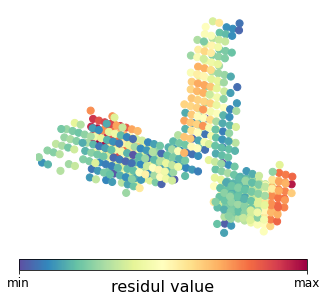

In [68]:
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(projection='3d')
ax2.dist=6
ax2.set_axis_off()

ax2.scatter(
    ijk_indices[:,0],
    ijk_indices[:,1],
    ijk_indices[:,2],
    s=50, alpha=1,
    cmap='Spectral_r',
    c=resid_sqsum
)

# Add legend    
norm = matplotlib.colors.Normalize(vmin=0, vmax=2.2)

cb_ax = fig.add_axes([0.3, 0.15, 0.4, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Spectral_r), ticks=[0, 2.2],
                  cax=cb_ax, orientation='horizontal')
cb.set_label("residul value", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['min','max'], fontsize=12) 

plt.savefig(fig_path + f'BF_Struct_vs_Func_linear_least-squares_regression_scaled-sqsum_residuals.png', dpi=300)
plt.show()

plt.show()

In [87]:
resid_results['(0, 0)']

0      0.002994
1     -0.021603
2      0.025446
3      0.013929
4     -0.013683
         ...   
558    0.250823
559    0.254964
560    0.234185
561    0.247100
562    0.103665
Name: (0, 0), Length: 563, dtype: float64

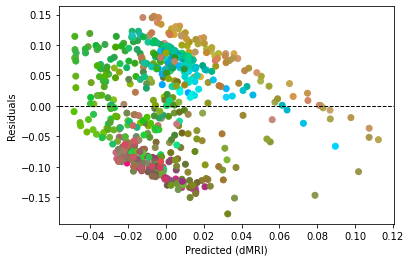

In [31]:
import matplotlib.pyplot as plt
gradi=3
dmri_g = nib.load(dmri_fname.format(gradi)).get_fdata()
plt.scatter(dmri_g[combined_mask==1].flatten(), resid_results['(3, 1)'], c=c_com)
plt.xlabel('Predicted (dMRI)')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.show()